In [1]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data

In [2]:
# def prelucrare_date():
#     csv = pd.read_csv('./stroke_risk_dataset.csv', encoding='utf-8')
#     csv = csv.drop(columns=["nausea_vomiting"])
#     gender = ['Male','Female']
#     dict_gender = {t: i + 1 for i, t in enumerate(gender)}
#     csv['gender'] = csv['gender'].map(dict_gender).fillna(-1).astype(int)
#     #impartim datle pentru linear regression si logistic regression in date de train si test
#     li_r_labels = torch.tensor(csv["stroke_risk_percentage"].values).float().unsqueeze(1)
#     lo_r_labels = torch.tensor(csv["at_risk"].values).float().unsqueeze(1)
#     # print(li_r_labels)
#     # print(lo_r_labels)
#     li_r_data = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
#     lo_r_data = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
#     # print(li_r_data)
#     # print(lo_r_data)
#     li_r_data = torch.tensor(li_r_data.values).float()
#     lo_r_data = torch.tensor(lo_r_data.values).float()
#     li_r_data, li_r_labels = shuffle(li_r_data, li_r_labels, random_state=0)
#     lo_r_data, lo_r_labels = shuffle(lo_r_data, lo_r_labels, random_state=0)
#     li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels = train_test_split(
#         li_r_data, li_r_labels, test_size=0.3, random_state=0)
#     lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels = train_test_split(
#         lo_r_data, lo_r_labels, test_size=0.3, random_state=0)
#     return li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels,lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels

In [3]:
# li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels,lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels=prelucrare_date()
# torch.save({
#     'train_data': li_r_train_data,
#     'test_data': li_r_test_data,
#     'train_labels': li_r_train_labels,
#     'test_labels': li_r_test_labels
# }, 'date_liniar_regression.pth')
# torch.save({
#     'train_data': lo_r_train_data,
#     'test_data': lo_r_test_data,
#     'train_labels': lo_r_train_labels,
#     'test_labels': lo_r_test_labels
# }, 'date_logistic_regression.pth')

In [2]:
def incarcare_date(path):
    date_salvate = torch.load(path,weights_only=True)
    x_train = date_salvate['train_data']
    x_test = date_salvate['test_data']
    y_train = date_salvate['train_labels']
    y_test = date_salvate['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [3]:
def normalizare_date(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [4]:
x_train,x_test,y_train,y_test = incarcare_date('date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalizare_date(x_train,x_test,y_train,y_test)
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [5]:
class LinearRegression(torch.nn.Module):
    def __init__(self, n_features, learning_rate=1e-2, momentum=0.5, epochs=15):
        super(LinearRegression, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        self.epochs = epochs
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        self.criterion = torch.nn.MSELoss()
    def forward(self, x):
        pred = self.lr(x)
        return pred
    # def forward_on_encrypted_data(self,enc_x):
    #     enc_pred = enc_x.dot(self.lr.weight.data.tolist()[0])+self.lr.bias.data.tolist()
    #     return enc_pred

    def fit(self, x_train, y_train):
        loss_values = []
        for e in range(1, self.epochs + 1):
            self.optimizer.zero_grad()
            pred = self.forward(x_train)
            loss = self.criterion(pred, y_train)
            loss.backward()
            self.optimizer.step()
            loss_values.append(loss.item())
            print(f"Loss at epoch {e}: {loss.item()}")
        sns.set_theme(style="darkgrid", palette="pastel")
        plt.figure(figsize=(8, 5))
        sns.lineplot(x=range(1, self.epochs + 1), y=loss_values, marker='o', linewidth=2.5, color="darkred")
        plt.xlabel('Epoci', fontsize=12)
        plt.ylabel('Pierdere', fontsize=12)
        plt.title('Evoluția pierderii în timpul antrenării pe setul de date necriptat', fontsize=14)
        # plt.savefig('li_r_loss_curve_training_on_clear_data.png')
        plt.show()


In [6]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

Loss at epoch 1: 0.5689983367919922
Loss at epoch 2: 0.538510262966156
Loss at epoch 3: 0.49566927552223206
Loss at epoch 4: 0.45008984208106995
Loss at epoch 5: 0.4063541293144226
Loss at epoch 6: 0.36635997891426086
Loss at epoch 7: 0.33066490292549133
Loss at epoch 8: 0.2991986870765686
Loss at epoch 9: 0.27162617444992065
Loss at epoch 10: 0.24752399325370789
Loss at epoch 11: 0.2264634668827057
Loss at epoch 12: 0.20804598927497864
Loss at epoch 13: 0.19191566109657288
Loss at epoch 14: 0.17776156961917877
Loss at epoch 15: 0.1653149276971817


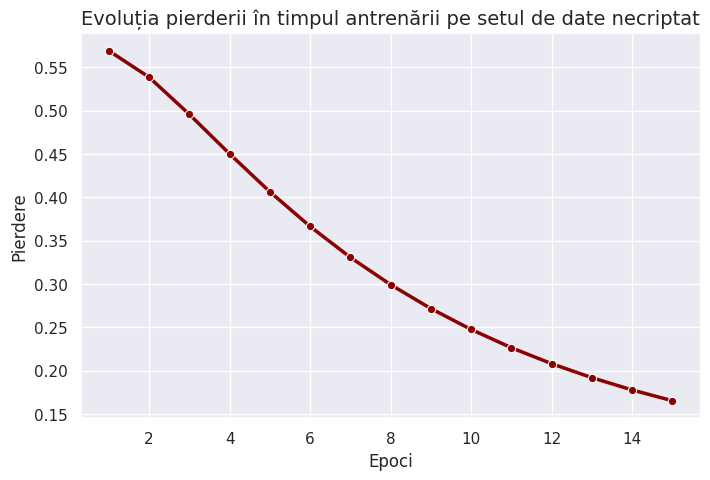

Antrenarea modelului pe date necriptate a durat:0.26469723300397163257 secunde


In [ ]:

#antrenare pe date clare
li_r_model = LinearRegression(n_features=x_train.shape[1])

t_start = time.perf_counter()
li_r_model.fit(x_train[:1000], y_train[:1000])
t_end = time.perf_counter()
print(f"Antrenarea modelului pe date necriptate a durat:{(t_end - t_start):.20f} secunde")

# save_model(li_r_model,'li_r_trained_on_clear_data.pkl')



In [7]:
def metrici_date_test_clare(model, x, y):
    t_start = time.perf_counter()
    pred = model.forward(x)
    t_end = time.perf_counter()
    print(f"predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    print(f"Predictions: {pred.shape}")
    print(f"Actual values: {y.shape}")
    y = y.detach().numpy()
    pred = pred.detach().numpy()
    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Valori Reale vs. Predicții', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    # plt.savefig("./li_r_trained_on_clear_data_predictions_on_clear_data.png")
    plt.show()
    return r2,mse

predictiile pe testul de date necriptate au durat:0.01446982399647822604 secunde
Predictions: torch.Size([700, 1])
Actual values: torch.Size([700, 1])
R^2 Score = 0.8674
MSE = 0.1371


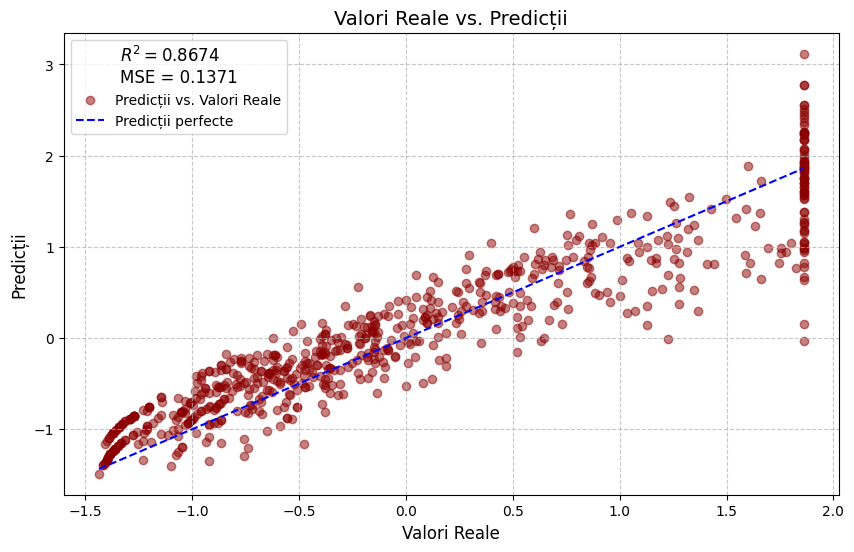

In [8]:
li_r_model = pickle.load(open("./li_r_trained_on_clear_data.pkl", 'rb'))
r2_clear_data, mse_clear_data=metrici_date_test_clare(li_r_model,x_test[:700],y_test[:700])

In [17]:
def importanta_caracteristicilor(model, feature_names):
    weights = model.lr.weight.detach().numpy().flatten()

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = np.array(feature_names)[sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_clear_data_feature_importance.png")
    plt.show()



16


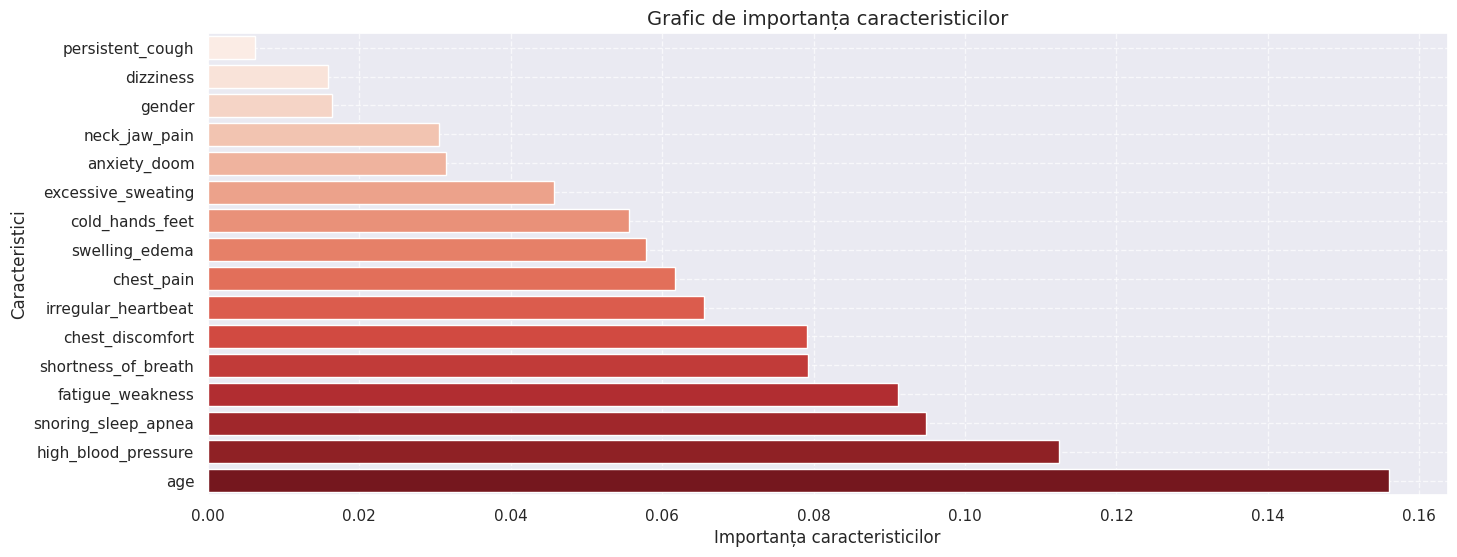

In [18]:
csv = pd.read_csv('./stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()
print(len(header))
importanta_caracteristicilor(li_r_model,header) 

preziceri pe date criptate

in openfhe exista mai multe security levels care pot fi setate
o sa extragem metrici pentru mai multi parametrii de SetSecurityLevel

In [9]:
table_list = []

In [10]:
multDepth = 2
scaleModSize = 40
batchSize = len(x_test[1]) #16
parameters = CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
parameters.SetRingDim(4096)
parameters.SetSecurityLevel(HEStd_NotSet)

cc = GenCryptoContext(parameters)

cc.Enable(PKE)
cc.Enable(KEYSWITCH)
cc.Enable(LEVELEDSHE)
cc.Enable(ADVANCEDSHE)
ring_dim = cc.GetRingDimension()
print(f"Dimensiunea inelului in CKKS {ring_dim}")
security_param= parameters.GetSecurityLevel()
print(f"Parametrul de securitate: {security_param}")
keys = cc.KeyGen()

#asigura ca evaluarea datelor criptate se face fara decriptatea lor
#cheile sunt derivate din secret key
cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)


Dimensiunea inelului in CKKS 4096
Parametrul de securitate: SecurityLevel.HEStd_NotSet


In [11]:
#x_test nu are o forma buna pentru biblioteca openfhe
print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))

torch.Size([10500, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, 3.038736343383789, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, -0.4168514609336853, -0.33037757873535156], [1.2492173910140991, 0.9948703050613403, -0.4117799401283264, 1.7292275428771973, 3.0457913875579834, 2.0500738620758057, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, 2.90977144241333, 2.4405479431152344, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156]]
<class 'list'>


In [12]:
def criptare_vector():
    enc_list=[]
    for x_t_l in tqdm(x_test_list, desc="criptare date"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [13]:
t_start = time.perf_counter()
enc_test_list = criptare_vector()
t_end = time.perf_counter()
print(f"Criptarea pe setul de date de test a durat {(t_end - t_start):.20f} secunde")

criptare date: 100%|██████████| 700/700 [00:03<00:00, 192.97it/s]

Criptarea pe setul de date de test a durat 3.63660594500106526539 secunde


In [14]:
def forward_on_encrypted_data(model,enc_x):
    weight = model.lr.weight.data.tolist()[0]
    bias = model.lr.bias.data.tolist()
    #encode weight si bias
    encoded_weights = cc.MakeCKKSPackedPlaintext(weight)
    encoded_bias = cc.MakeCKKSPackedPlaintext(bias)
    enc_sum = cc.EvalInnerProduct(enc_x, encoded_weights,16)
    enc_pred = cc.EvalAdd(enc_sum, encoded_bias)
    return enc_pred

In [15]:
def metrici_date_test_criptate(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    t_pred = t_end - t_start
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    t_decrip_pred = t_end - t_start
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    print(list_pred[0])
    print(list_pred[0].real)
    # list_pred = [x.real for x in list_pred]
    print(list_pred[0])
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Valori Reale vs. Predictii', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.savefig("./li_r_trained_on_clear_data_predictions_on_encrypted_data.png")
    plt.show()
    return r2
  
    

Predictii: 100%|██████████| 700/700 [00:15<00:00, 44.77it/s]


Predictiile pe testul de date criptat au durat:15.64074859600077616051 secunde
Decriptarea predictiilor a durat:2.66202449899719795212 secunde
0.6909748737519504
0.6909748737519504
0.6909748737519504
R^2 Score = 0.8674
MSE = 0.1371


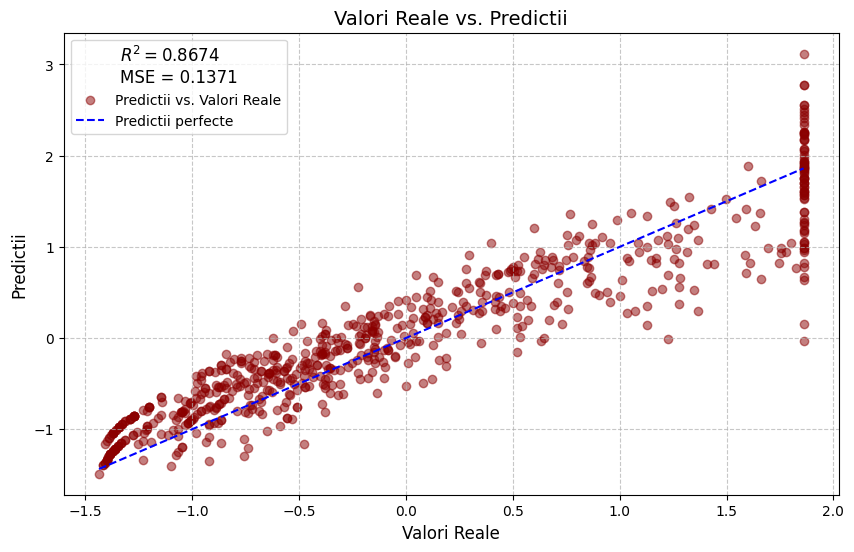

In [16]:
r2 = metrici_date_test_criptate(li_r_model,enc_test_list,y_test[:700])

se vede ca diferenta de precizie este inexistenta intre prezicerile pe date clare si cele pe date criptate

in continuare vom vedea cum criptarea poate sa influenteze precizia si intre ce valori se situeaza de fapt precizia pe datele de test 


In [17]:
def interval_de_precizie(model, enc_x, y):
     #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    t_pred = t_end - t_start
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
   
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    t_dec_pred = t_end - t_start
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")
    return r2, mse, t_pred, t_dec_pred

In [18]:
mse_list = []
r2_list = []
sum_timp_criptare = 0
sum_timp_pred = 0
sum_timp_dec_pred =0
for incercari in range(5):
    t_start = time.perf_counter()
    enc_x_test = criptare_vector()
    t_end = time.perf_counter()
    t_cript = t_end-t_start
    sum_timp_criptare +=t_cript
    r2,mse,t_pred, t_dec_pred = interval_de_precizie(li_r_model,enc_x_test,y_test[:700])
    sum_timp_pred +=t_pred
    sum_timp_dec_pred += t_dec_pred
    mse_list.append(mse)
    r2_list.append(r2)

avg_timp_criptare = sum_timp_criptare/5
avg_timp_pred = sum_timp_pred/5
avg_timp_dec_pred = sum_timp_dec_pred /5

Predictii: 100%|██████████| 700/700 [00:17<00:00, 39.39it/s]


Predictiile pe testul de date criptat au durat:17.77325240999925881624 secunde
Decriptarea predictiilor a durat:2.96376304799923673272 secunde
R^2 Score = 0.8674
MSE = 0.1371


Predictii: 100%|██████████| 700/700 [00:17<00:00, 40.61it/s]


Predictiile pe testul de date criptat au durat:17.23985268999967956915 secunde
Decriptarea predictiilor a durat:3.08971902299526846036 secunde
R^2 Score = 0.8674
MSE = 0.1371


Predictii: 100%|██████████| 700/700 [00:19<00:00, 35.43it/s]


Predictiile pe testul de date criptat au durat:19.77122816899645840749 secunde
Decriptarea predictiilor a durat:2.76263589900190709159 secunde
R^2 Score = 0.8674
MSE = 0.1371


Predictii: 100%|██████████| 700/700 [00:16<00:00, 43.26it/s]


Predictiile pe testul de date criptat au durat:16.18618574100401019678 secunde
Decriptarea predictiilor a durat:3.12878111800091573969 secunde
R^2 Score = 0.8674
MSE = 0.1371


Predictii: 100%|██████████| 700/700 [00:17<00:00, 40.39it/s]


Predictiile pe testul de date criptat au durat:17.33370733100309735164 secunde
Decriptarea predictiilor a durat:3.64642261100379982963 secunde
R^2 Score = 0.8674
MSE = 0.1371


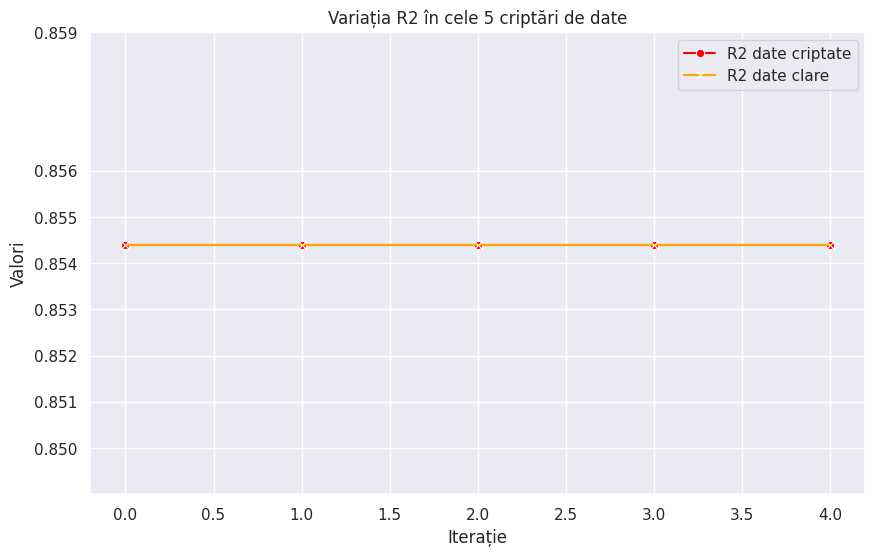

In [ ]:
# data = {
#     'Iterație': [i for i in range(5)],
#     'R2 Date Criptat': r2_list,
#     'R2 Date clare': [r2_clear_data] * 5, 
# }

# df = pd.DataFrame(data)

# plt.figure(figsize=(10, 6))

# sns.lineplot(data=df, x='Iterație', y='R2 Date Criptat', label='R2 date criptate', marker='o', color='red')
# sns.lineplot(data=df, x='Iterație', y='R2 Date clare', label='R2 date clare', marker='x', color='orange')


# plt.title('Variația R2 în cele 5 criptări de date')
# plt.xlabel('Iterație')
# plt.ylabel('Valori')

# y_ticks = [ 0.85,0.851,0.852,0.853,0.854,0.855,0.856,0.859]
# plt.yticks(y_ticks)

# plt.ylim(0.849, 0.859)  

# plt.legend()

# plt.savefig("li_r_trained_on_clear_data_variance_predictions_on_encrypted_data.png")

# plt.show()
    

In [ ]:
(security_param,ring_dim,avg_timp_criptare,avg_timp_pred,avg_timp_dec_pred,r2)

(<SecurityLevel.HEStd_NotSet: 6>,
 8192,
 5.787615904799895,
 25.660830002198054,
 4.381745896398206,
 0.8673796908289919)

(<SecurityLevel.HEStd_128_classic: 0>,
 16384,
 12.626807427800667,
 49.710884650399386,
 8.885370516202238,
 0.8281465457088487)

In [ ]:
table_list.append((security_param,ring_dim,avg_timp_criptare,avg_timp_pred,avg_timp_dec_pred,r2))
print(table_list)

[(<SecurityLevel.HEStd_128_classic: 0>, 16384, 12.414008122199448, 52.7766469226015, 8.681446001199948, 0.8673796908294509), (<SecurityLevel.HEStd_192_classic: 1>, 16384, 13.865444027599006, 52.50295394300046, 8.52702609479893, 0.867379690836426), (<SecurityLevel.HEStd_NotSet: 6>, 4096, 2.8747429100010775, 14.573816010399606, 2.2272443850015406, 0.8673796908323975), (<SecurityLevel.HEStd_NotSet: 6>, 8192, 5.787615904799895, 25.660830002198054, 4.381745896398206, 0.8673796908289919)]
